# Explore KPIs to predict special historical events in the stock prices 

We want to study the evolution of the stock prices for a given example, in this case the index S&P 500 since it is a good indicator of stock evolution over the years and there is data available since 1950.

Specially, we want to 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download S&P 500 Index historical data
yf.pdr_override()
data = pdr.get_data_yahoo("^GSPC", start="1951-01-01", end="2017-04-30")

[*********************100%***********************]  1 of 1 downloaded


In [3]:
data_ = data.reset_index()
data_['Date_str'] = data_['Date'].dt.date.astype(str)
data_['Volume'] = data_['Volume'].astype(int)

In [4]:
data_.to_csv('../data/S_and_P_500_50_18.csv', index=False, encoding='utf-8')

## Time Series Decomposition

In [5]:
# Manual extraction of the exponential trend applying the logarithm of the values
data_['log_trend_open'] = data_['Open'].apply(lambda x: np.log(x))
data_['log_trend_volume'] = data_['Volume'].apply(lambda x: np.log(x))

### Is there any linear relationship between Close prices and volumes (total, trend, residuals)?

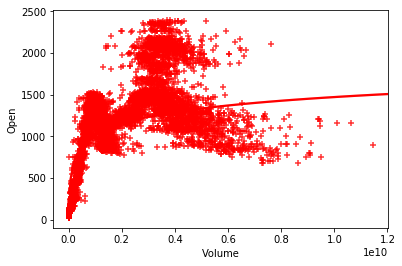

In [11]:
sns.regplot("Volume","Open", data=data_, logx=True, color='r', marker="+")

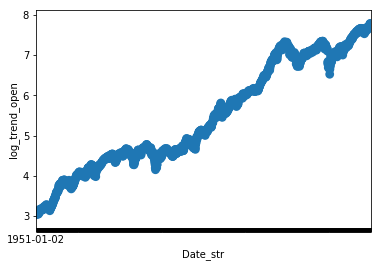

In [12]:
# Data after extracting the trend
ax = sns.pointplot(x='Date_str',y='log_trend_open', data=data_.iloc[::10])
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 100000 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

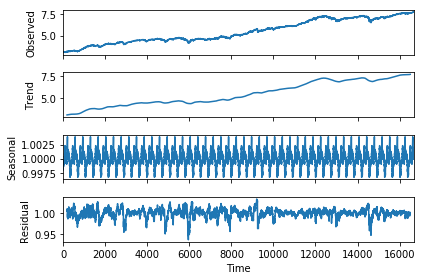

In [13]:
# Decomposition of the closing values
result_open = seasonal_decompose(data_['log_trend_open'].tolist(), model='multiplicative', freq=365*1, 
                                 two_sided=True)
result_open.plot()
plt.show()

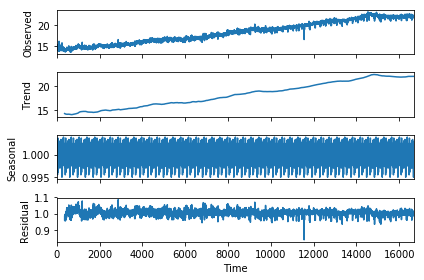

In [14]:
# Decomposition of the volume values
result_volume = seasonal_decompose(data_['log_trend_volume'].tolist(), model='multiplicative', freq=365*1,
                                  two_sided=False)
result_volume.plot()
plt.show()

In [15]:
residuals = pd.DataFrame({'open':result_open.resid, 'volume':result_volume.resid})

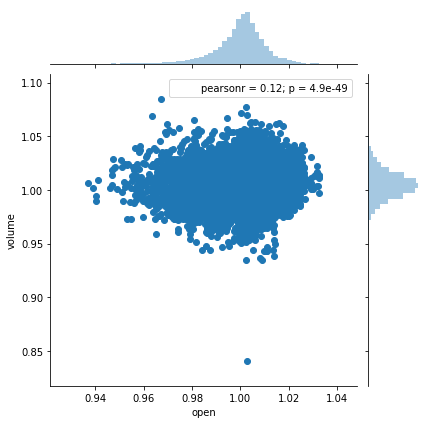

In [16]:
# Plot the residuals linear relation
sns.jointplot("open", "volume", data=residuals)

In [17]:
# Visualize the linear relationship between close values and volumnes without seasonality
trend_resi = pd.DataFrame({'resid_open':result_open.resid,'trend_open':result_open.trend,
              'resid_volume':result_volume.resid,'trend_volume':result_volume.trend}).fillna(0)

In [18]:
trend_resi['volume'] = trend_resi.apply(lambda x: x['resid_volume'] + x['trend_volume'], axis=1)
trend_resi['open'] = trend_resi.apply(lambda x: x['resid_open'] + x['trend_open'], axis=1)

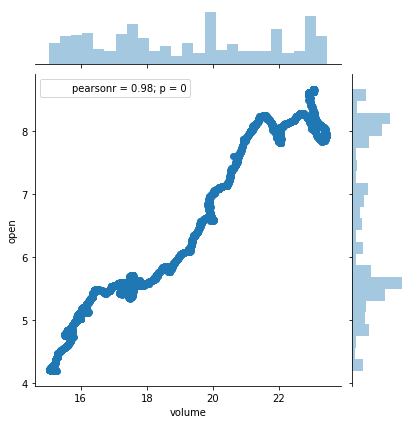

In [19]:
sns.jointplot("volume","open", data=trend_resi[(trend_resi['open']>0) & 
                                                (trend_resi['volume']>0)])

#### Correlation between stock price and volume: Conclusions

* When time series are decomposed and only residuals are considered for the study of the correlation, we do not see anything.
* When time series are decomposed and trend + residuals are considered for the study of the correlation, we see a linear relationship that it may be mainly related to the correlation between the increase of the prices and the number of transactions over the history.
* When choosing a different window size or working with the logarithmic values, the conclusions were the same.

### Can we recognize crisis considering values far from the mean of the residuals?

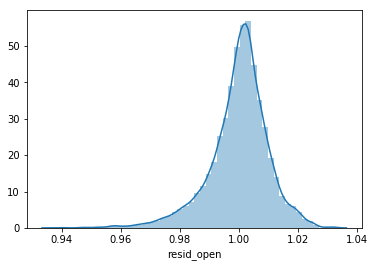

In [20]:
sns.distplot(trend_resi[trend_resi['resid_open']>0]['resid_open'])

In [21]:
# Obtain the confidence interval assuming the data is normally distributed and a confidence of 0.95
mean_open = trend_resi[trend_resi['resid_open']>0]['resid_open'].mean()
std_open = trend_resi[trend_resi['resid_open']>0]['resid_open'].std()
sem = std_open / np.sqrt(len(trend_resi[trend_resi['resid_open']>0]['resid_open']))

# Distribution when using absolute values trend + residual ws = 1 year
#interval_max_1, interval_min_1, interval_max_2, interval_min_2 = 450, 50, 1550, 1000

# Distribution when using absolute values trend + residual ws = 5 year
#interval_max_1, interval_min_1, interval_max_2, interval_min_2 = 250, 50, 1350, 1100

# Distribution when using logarithmic values trend + residual ws = 1 year
#interval_max_1, interval_min_1, interval_max_2, interval_min_2 = 5.9, 4.8, 8.5, 7.8

# Distribution when using logarithmic values trend + residual ws = 5 year
#interval_max_1, interval_min_1, interval_max_2, interval_min_2 = 6, 5, 8.2, 7.8

# Distribution when using residual decomposed values (logarithmic or absolute values)
interval_max_1, interval_min_1 = mean_open + std_open, mean_open - std_open

print(mean_open, std_open, interval_max_1, interval_min_1)

0.9999509594575504 0.010105036691134927 1.0100559961486852 0.9898459227664155


In [22]:
# Select periods out of the given intervals with trend + residuals
#period_1_idx = trend_resi[(trend_resi['open']<interval_max_1) & (trend_resi['open']>interval_min_1)].index.tolist()
#period_2_idx = trend_resi[(trend_resi['open']>interval_max_1) & (trend_resi['open']<interval_min_2)].index.tolist()
#period_3_idx = trend_resi[(trend_resi['open']<interval_max_2) & (trend_resi['open']>interval_min_2)].index.tolist()

# Select periods out of the given intervals with residuals
period_1_idx = trend_resi[(trend_resi['resid_open']<interval_min_1) ].index.tolist()
period_2_idx = trend_resi[(trend_resi['resid_open']<interval_max_1) & (trend_resi['resid_open']>interval_min_1)].index.tolist()
period_3_idx = trend_resi[(trend_resi['resid_open']>interval_max_1)].index.tolist()

In [23]:
data_crisis = data_.copy()
data_crisis['stock_price_annot'] = 'mode_0'
data_crisis.ix[period_1_idx,'stock_price_annot'] = 'mode_1'
data_crisis.ix[period_2_idx,'stock_price_annot'] = 'mode_2'
data_crisis.ix[period_3_idx,'stock_price_annot'] = 'mode_3'

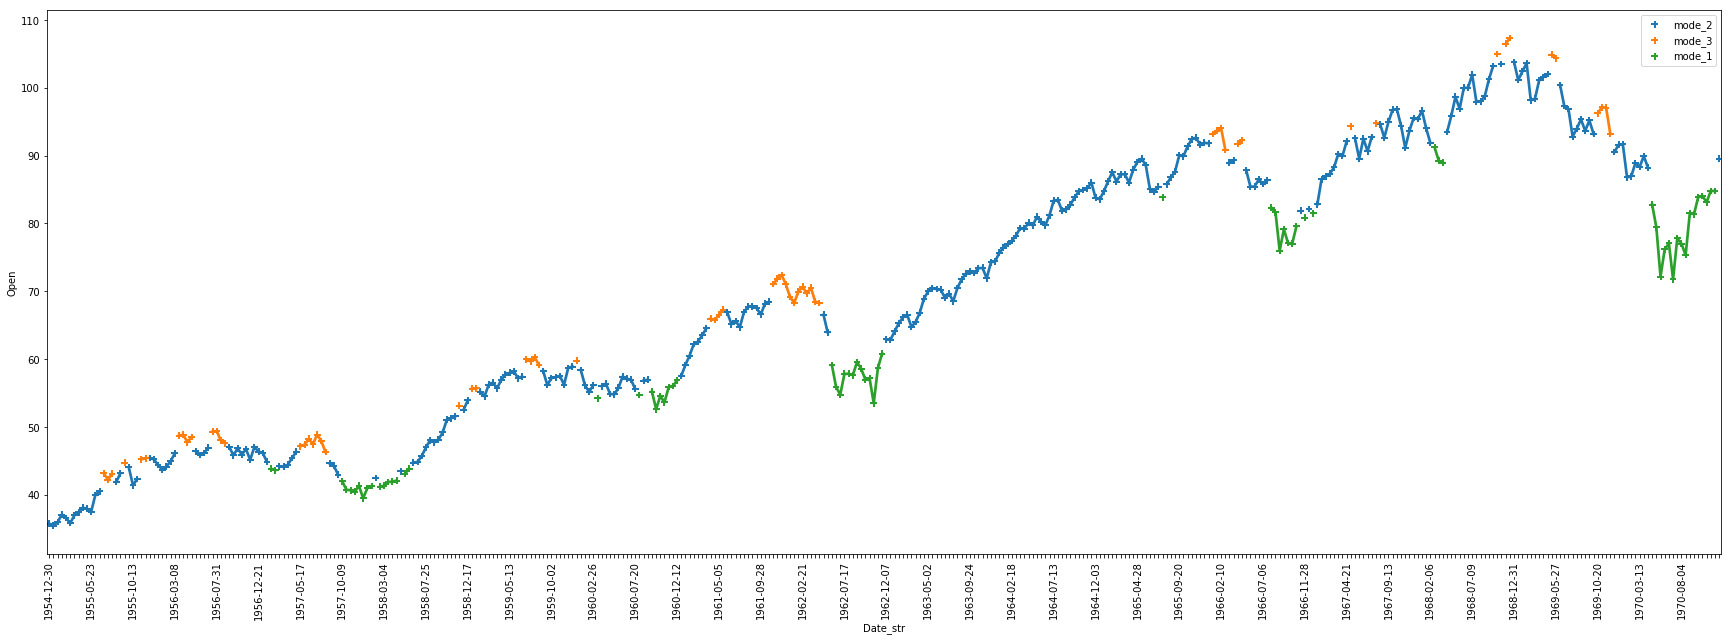

In [41]:
# Original data
plt.figure(figsize=(30,10))
ax = sns.pointplot(x='Date_str',y='Open', data=data_crisis.iloc[1000:5000:10], hue='stock_price_annot', markers='+')
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.legend()
_ = plt.xticks(rotation=90)

#### Crisis period annotation with stock values: Conclusions
**1. Using residuals + trend with original Open prices (ws = 1 year)**
    * The intervals are selected manually including ~80% of the area under the two peaks observed in the distribution
    * We see least common prices at the peaks before all crisis after the wall and the period after the second world war
    * There are two peaks in the distribution of prices, the first corresponts to the cold war period and the second to the periods before and after the peaks of the crisis after the cold war
    * The last period is splited into three parts, first between the end of the cold war and the 2000, in 2002 in the crisis depression and in 2009 in the next crisis depresion again.
    * There is a clear correlation between historical events and stock market prices. This is pretty nice for historical analysis but it is not useful for prediction of a new crisis. The event detection is biased by the historical evolution trend of stock and specific crisis (like in the 70's) are not detected.

**2. Using residuals with original Open prices (ws = 1 year)**
    * The intervals are selected by using one standard deviation before and after the mean in the distribution
    * The left tail of the distribution correlates pretty well with the steepest changes in the stock that use to happen just before and after the crisis. These periods are likely the most active.
    * The next period corresponds to more stable times where no big changes are happening. This is where the frequencies in the distribution are higher.
    * The last period or the right tail of the distribution are those depresion times where the stock prices went deep down.
    * It is predicting decisive events for the stock market in the different crisis over the history. This could be a great approach to consider for crisis prediction.
    
**3. Using residuals + trend with logarithmic Open prices (ws = 1 year)**
    * The intervals are selected manually including ~80% of the area under the two peaks observed in the distribution
    * As specified in 1. it recognizes even clearer historical periods but it is not useful for crisis annotations. It is interesting that the current period had the same label as the period just after the second world war, both periods are characterized not only by a steeped grow of stock prices but also by a small crisis in between of the strong growth.

**4. Using residuals with logarithmic Open prices (ws = 1 year)**
    * The intervals are selected by using one standard deviation before and after the mean in the distribution
    * The results are almost the same than in point 2. but it identifies the peaks and crisis as wider periods.

**5. Using residuals + trend with original Open prices (ws = 5 years)**
    * The intervals are selected by using one standard deviation before and after the mean in the distribution
    * As specified in 1. it recognizes well historical periods but it is not useful for crisis annotations.

**6. Using residuals with original Open prices (ws = 5 years)**
    * The intervals are selected by using one standard deviation before and after the mean in the distribution
    * The results are almost the same than in point 2. but it identifies clearer the peaks and crisis periods.

**7. Using residuals + trend with logarithmic Open prices (ws = 5 years)**
    * The intervals are selected manually including ~80% of the area under the two peaks observed in the distribution
    * As specified in 1. it recognizes even clearer historical periods but it is not useful for crisis annotations. It is interesting that the current period had the same label as the period just after the second world war, both periods are characterized by a steeped grow of stock prices. In this case, as a difference with the 1 year window size, the small crisis period is not included in this label after the second world war.

**8. Using residuals with logarithmic Open prices (ws = 5 years)**
    * The intervals are selected by using one standard deviation before and after the mean in the distribution
    * The results are almost the same than in point 2. but it identifies clearer the peaks and crisis as wider periods. It could be the perfect tool for labeling critical periods in the stock market.

## Can one identify a crisis by evaluating the percentage of change in the close price from one day to the next?

In [25]:
# Calculate the percentage of variation with respect of the close price of the previous day
data_['variation_percent'] = 0.0
for i in range(len(data_)):
    if i == 0:
        next
    else:
        variation = 100 - data_.ix[i,'Open'] * 100 / data_.ix[i-1,'Open']
        data_.ix[i,'variation_percent'] = variation

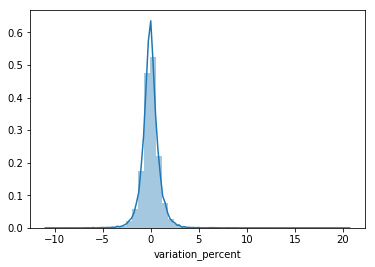

In [26]:
sns.distplot(data_['variation_percent'])

In [27]:
mean_open = data_['variation_percent'].mean()
std_open = data_['variation_percent'].std()
sem = std_open / np.sqrt(len(data_['variation_percent']))

ci_min, ci_max = st.t.interval(0.75, len(data_['variation_percent'])-1, 
                               loc=np.mean(data_['variation_percent']), 
                               scale=st.sem(data_['variation_percent']))

print(mean_open, std_open, ci_max, ci_min)

-0.032946017064862214 0.9463596163331734 -0.02451927117410927 -0.04137276295561516


In [28]:
# Select data out of the confidence interval as special events
period_1_idx = data_[(data_['variation_percent']<ci_min) ].index.tolist()
period_2_idx = data_[(data_['variation_percent']<ci_max) & (data_['variation_percent']>ci_min)].index.tolist()
period_3_idx = data_[(data_['variation_percent']>ci_max)].index.tolist()

data_crisis['var_percent_annot'] = 'mode_0'
data_crisis.ix[period_1_idx,'var_percent_annot'] = 'mode_1'
data_crisis.ix[period_2_idx,'var_percent_annot'] = 'mode_2'
data_crisis.ix[period_3_idx,'var_percent_annot'] = 'mode_3'

In [31]:
data_crisis.shape

(16691, 12)

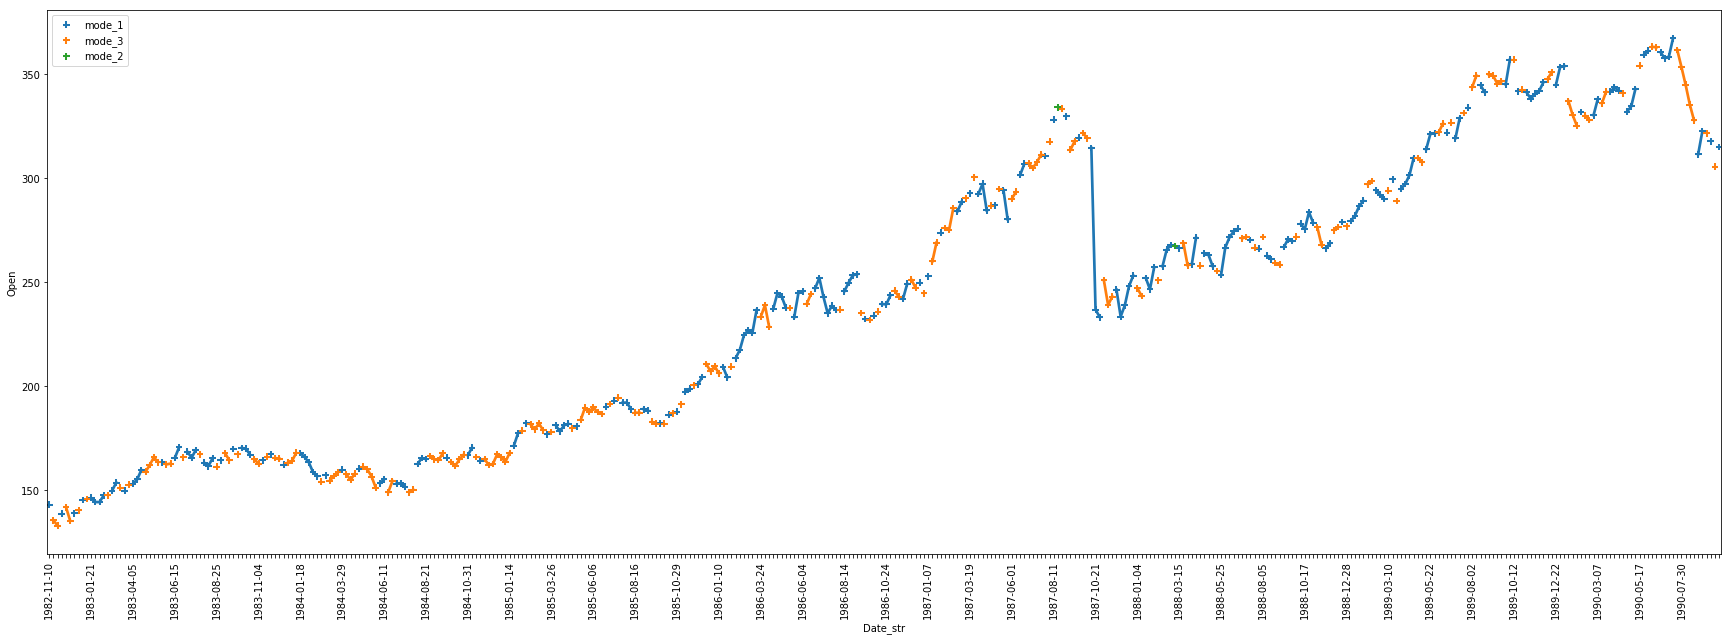

In [37]:
# Original data
plt.figure(figsize=(30,10))
ax = sns.pointplot(x='Date_str',y='Open', data=data_crisis.iloc[8000:10000:5], hue='var_percent_annot', markers='+')
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.legend()
_ = plt.xticks(rotation=90)

#### Crisis period annotation with percentage of change: Conclusions
* Even using different confidence intervals or manaully defined intervals of 1 standard deviation away from the mean as the definition of special events or normal we do not see a correlation between this KPI and special events around crisis. 
* We see that those days where the percentage of variation in the price was not that usual are not correlated with a crisis coming, it has a small effect on the overal trend. All types of percentage of change are distributed all over the history.

In [30]:
data_crisis.to_csv('../data/S_and_P_500_50_18_crisis.csv', index=False, encoding='utf-8')

### Conclusions
* We can label special events (strong growths, crisis) automatically by decomposing logarithmic open stock prices in a window size of 5 years and choosing 3 periods based on 80% most frequent prices, left tail and right tail of the distribution. For annotation purposes, the best result was achieved by using two sided seasonal decomposition.
* We see a similar trend on the stock prices in the last years and after the second world war which is an interesting fact.
* We do not see a linear correlation between stock prices and volume of transactions.
* There is not a correlation between percentage of variation of stock prices per day and special events happening.